# House Pricing

## Problem Statement

We would like to predict the house of a house based on its characteristics.

In [4]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_csv("house_prices.csv")
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df=df[df["TotalSF"]<6000]

In [6]:
# Data Preparation
# vamos a guardar siempre el input en X
# las variables de entradas DEBEN SER UNA MATRIX
# la variable de salida DEBE SER UNA SERIE
X = df[['TotalSF']] # pandas DataFrame
y = df["SalePrice"] # pandas Series

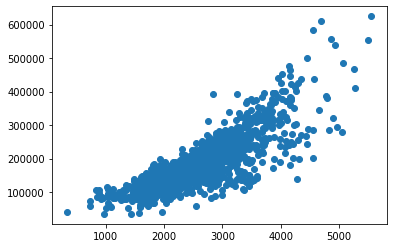

In [5]:
plt.scatter(X,y)

## Linear Regression

In [6]:
# load the library
# importamos solo lo que necesitamos de sklearn por ser organizados
from sklearn.linear_model import LinearRegression

In [7]:
# crear una instancia del modelo
reg = LinearRegression()

In [8]:
# entrenamos el modelo regresor con fit
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
reg.coef_

array([83.79128706])

In [10]:
reg.intercept_

-33573.95266496143

In [11]:
# hago predicciones
# el input debe ser un data frame, igual que era la X.
# por eso ponemos doble corchete
reg.predict([[2540], [3500], [500]])

array([179255.91647975, 259695.552062  ,   8321.69086746])

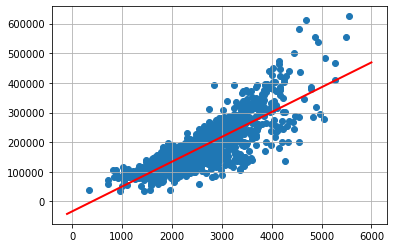

In [14]:
# vamos a dibujar la recta
xtest = np.linspace(-100, 6000)
coef = reg.coef_
yline = coef*xtest + reg.intercept_
plt.scatter(X,y)
plt.plot(xtest, yline, 'r-', lw=2)
plt.grid(True)

In [7]:
# Para medir si mi modelo es bueno o malo necesito métricas
# y necesito un training set y un test set
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10)

In [17]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### MAE en sklearn

#### Calculado con sklearn

In [26]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(reg.predict(X_test),y_test)

24845.494674200978

#### Calculado a mano con numpy

In [19]:
import numpy as np

In [28]:
# reg.predict(X_test) es la y predicción
myMAE = np.mean(np.abs(reg.predict(X_test) - y_test))
myMAE
# salen 24 mil dolares de error mas o menos

24845.494674200967

### MAPE no está en sklearn, lo hacemos a mano

In [30]:
myMAPE = np.mean(np.abs(reg.predict(X_test) - y_test)/y_test)
myMAPE
# sale un 15% de error.

0.15427378993215754

## Vamos a intentar mejorar el modelo

### K vecinos

In [9]:
# Load the library 
from sklearn.neighbors import KNeighborsRegressor 
# Create an instance. Define el número de vecinos
regk = KNeighborsRegressor(n_neighbors=2) 
# Fit the data.
regk.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [10]:
help(KNeighborsRegressor)

Help on class KNeighborsRegressor in module sklearn.neighbors.regression:

class KNeighborsRegressor(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedFloatMixin, sklearn.base.RegressorMixin)
 |  KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Regression based on k-nearest neighbors.
 |  
 |  The target is predicted by local interpolation of the targets
 |  associated of the nearest neighbors in the training set.
 |  
 |  Read more in the :ref:`User Guide <regression>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are we

In [35]:
# calcular MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(regk.predict(X_test),y_test)

28375.04794520548

### Cross Validation

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(regk,X,y,cv=5,scoring="neg_mean_squared_error")
# regk = nuestro modelo SIN ENTRENAR. Lo entrena por debajo en cada iteración.
# X = input
# y = output
# cv = 5 = cuantoss splits hago
# scoring = métrica que quiero conseguir.
# "neg_mean_squared_error" = nos da el MSE en negativo. No pasa nada, 
# nosotros lo positivizamos y calculamos la raíz para calcular el RMSE

array([-2.86710308e+09, -2.22082508e+09, -3.07547381e+09, -2.51360534e+09,
       -2.88836301e+09])

In [13]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv='warn', n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score='raise-deprecating')
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like
        The data to fit. Can be for example a list, or an array.
    
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" `cv` instance
        (e.g., `GroupKFold`).
    
    scoring : string, callabl

Como "cross_val_score" nos devuelve un vector con 5 valores del negativo del MSE, ,abajo hago el valor absoluto y luego su raíz cuadrada y luego la media de los valores del vector

In [39]:
np.mean(np.sqrt(np.abs(cross_val_score(regk, X, y, cv=5,scoring="neg_mean_squared_error"))))

52001.45670809731

### GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

regk_test = GridSearchCV(KNeighborsRegressor(),
                       param_grid={"n_neighbors":np.arange(3,50)},
                       cv=5,
                        scoring="neg_mean_absolute_error")

# KNeighborsRegressor(): modelo a testear
# param_grid =diccionario con "variable": sus valores
# me devuelve la INSTANCIA del mejor modelo de la iteración. Es decir,
# prepara la búsqueda paramétrica del mejor parámetro. Pero luego tengo que entrenar.
# cv : cuántos cross validation quiero hacer

In [15]:
# Ojo lo de antes era solo una instancia, todavía no está calculado el mejor modelo
# Necesito entrenar con fit() para de verdad calcular el mejor modelo.
regk_test.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

sklearn.model_selection._search.GridSearchCV

In [18]:
# Una vez entrenado ya puedo sacar estos datos, best_estimator, etc.
# este es el mejor modelo encontrado
regk_test.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=44, p=2,
                    weights='uniform')

In [48]:
# estos son los mejores parámetros encontrados
regk_test.best_params_

{'n_neighbors': 44}

In [49]:
# esta es la mejor métrica sacada
regk_test.best_score_

-30279.436191815057

## Decision Tree

In [53]:
# Load the library
from sklearn.tree import DecisionTreeRegressor
# Create an instance
regd = DecisionTreeRegressor(max_depth=3,
                            min_samples_leaf=20)


In [54]:
# Fit the data
regd.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### RandomizedSearchCV

In [56]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
reg_dt_test = RandomizedSearchCV(DecisionTreeRegressor(),
                                param_distributions={"max_depth":[2,3,5,8,10],
                                           "min_samples_leaf":[5,10,15,20,30,40]},
                                cv = 5,
                                scoring="neg_mean_absolute_error",
                                n_iter=5)
# n_iter -> de la malla de param_distributions cuántos valores random quiero probar
# ya está preparada la instancia del modelo. Ahora tengo que entrenarlo

In [62]:
reg_dt_test.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=None,
                                                   splitter='best'),
                   iid='warn', n_iter=5, n_jobs=None,
                   param_dis